# Imports

In [43]:
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# Utils

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures

def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    """
    Takes the values from the target variable and the predictions
    and draws the graphs for each variable. 
    Saves plots to pdf with `plot_title`.pdf
    Parameters:
        y_test (pd.DataFrame): The validation target values.
        y_pred (pd.DataFrame): The predictions target values.
        plot_title (string, optional): The title of plot.
"""
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig("results/"+plot_title+'.pdf')
    plt.show()


def custom_train_test_split(X, y, test_size=0.2, drop=True, columns_to_drop=[]):
    """
    Splits the dataset into training and testing sets based on unique trajectory IDs.
    Parameters:
        X (pd.DataFrame): The feature dataset containing a 'trajectory_id' column.
        y (pd.DataFrame): The target dataset containing a 'trajectory_id' column.
        test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
        drop (Boolean): Helper flag to decide weather to drop any columns or not
        columns_to_drop (list, optional): List of columns to drop from the feature dataset. Default is an empty list.
    Returns:
        tuple: A tupple containing the following:
            - X_train (pd.DataFrame): The training set of the feature dataset.
            - X_test (pd.DataFrame): The testing set of the feature dataset.
            - y_train (pd.DataFrame): The training set of the target dataset.
            - y_test (pd.DataFrame): The testing set of the target dataset.
    """
    # Get unique trajectory_ids
    unique_ids = X['trajectory_id'].unique()
    
    # Split the trajectory_ids into train and test sets
    train_ids, test_ids = train_test_split(unique_ids, test_size=test_size)

    # Split the data based on the trajectory_ids
    X_train = X[X['trajectory_id'].isin(train_ids)]
    X_test = X[X['trajectory_id'].isin(test_ids)]
    y_train = y[y['trajectory_id'].isin(train_ids)]
    y_test = y[y['trajectory_id'].isin(test_ids)]
    
    if drop:
        X_columns_drop = ['trajectory_id', 'Id'] + columns_to_drop
        Y_columns_drop = ['trajectory_id', 'Id'] + columns_to_drop

        # Drop the specified columns from X and y
        X_train = X_train.drop(columns=X_columns_drop)
        X_test = X_test.drop(columns=X_columns_drop)
        y_train = y_train.drop(columns=Y_columns_drop)
        y_test = y_test.drop(columns=Y_columns_drop)
    
    return X_train, X_test, y_train, y_test

# Rename function - GRID Search sklean
def train_model(pipeline: Pipeline,
                   X_train: pd.DataFrame, 
                   X_val: pd.DataFrame,
                   y_train: pd.DataFrame,
                   y_val: pd.DataFrame):
    """
    Evaluates the performance of a machine learning model pipeline on given data.

    This function splits the data into training and testing sets using a custom split function,
    fits the model pipeline on the training data, and then evaluates the model's performance
    on both the training and testing sets. It prints the mean squared error for both sets.

    Parameters:
        pipeline (Pipeline): The machine learning pipeline to be evaluated.
        X (pd.DataFrame): The input features for the model.
        y (pd.DataFrame): The target values for the model.
    Returns:
        y_pred_train: The prediction of the train dataset
        y_pred_val: The prediction of the validation dataset
        model: The model created
    """
    # Creates a model based on the pipeline passed
    model = pipeline.fit(X_train, y_train)
    # Check performance on train
    y_pred_train = model.predict(X_train)

    # Check performance on val
    y_pred_val = model.predict(X_val)
    return y_pred_train, y_pred_val, model

def validate_poly_regression(X_train: pd.DataFrame,
                             y_train: pd.DataFrame,
                             X_val: pd.DataFrame,
                             y_val: pd.DataFrame,
                             regressor=None, 
                             degrees=range(1,15), 
                             max_features=None,
                             plot=False
                            ):

    best_rmse = float('inf')
    best_model = None
    best_degree = None

    for degree in degrees:
        model = make_pipeline(StandardScaler() ,PolynomialFeatures(degree=degree), regressor if regressor else LinearRegression())

        # Fit the pipeline on the training data
        #print("Fitting the model")
        model.fit(X_train, y_train)

        # Predict on the training model
        y_pred_train = model.predict(X_train)
        # print("rmse for training: "+str(root_mean_squared_error(y_train, y_pred_train)))

        # Predict on the validation data
        #print("Preddicting the model")
        y_pred = model.predict(X_val)

        # Calculate RMSE
        rmse = root_mean_squared_error(y_val, y_pred)
        # Print the number of features generated by PolynomialFeatures
        num_features = model.named_steps['polynomialfeatures'].n_output_features_
        print(f"Degree: {degree}, RMSE: {rmse}, Number of features: {num_features}")

        # Update the best model if the current one is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_degree = degree

    print(f"Best Degree: {best_degree}, Best RMSE: {best_rmse}")
    return best_model, best_rmse, best_degree



In [45]:
df = pd.read_csv("../data/mlNOVA/mlNOVA/X_train.csv")

# Model Analysis for the Three Body Problem
## The problem
The problem consists in predicting positions at an instant t given a set of initial positions. 
This problem will be aproached as a multivariate regression, and we'll compare the results of using different types of regressions.

In [46]:
# Cleaning the data
# Create the trajectory_id column
df['trajectory_id'] = df['Id'] // 257
# Filter out rows where all columns except 'Id' and trajectory_Id are zero
df_filtered = df.loc[~(df.drop(columns=['Id','trajectory_id']) == 0).all(axis=1)]
df[df['trajectory_id'] == 157]

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id,trajectory_id
40349,0.000000,1.000000,0.000000,0.000000,0.000000,-0.006029,0.411829,0.000000,0.000000,-0.993971,-0.411829,0.000000,0.000000,40349,157
40350,0.039062,0.999222,0.000207,-0.039848,0.010623,-0.005786,0.411289,0.012472,-0.027653,-0.993436,-0.411497,0.027376,0.017030,40350,157
40351,0.078125,0.996885,0.000830,-0.079867,0.021279,-0.005053,0.409668,0.025035,-0.055369,-0.991831,-0.410499,0.054831,0.034089,40351,157
40352,0.117188,0.992978,0.001871,-0.120228,0.032003,-0.003827,0.406962,0.037782,-0.083211,-0.989151,-0.408833,0.082446,0.051208,40352,157
40353,0.156250,0.987485,0.003332,-0.161116,0.042829,-0.002098,0.403165,0.050812,-0.111244,-0.985387,-0.406497,0.110303,0.068415,40353,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40601,9.843750,-2.502845,0.957132,-0.401091,0.204687,1.165911,-0.700134,0.690975,0.042212,1.336935,-0.256998,-0.289884,-0.246899,40601,157
40602,9.882810,-2.518426,0.965095,-0.396626,0.202979,1.194048,-0.695157,0.748944,0.217154,1.324377,-0.269938,-0.352318,-0.420133,40602,157
40603,9.921880,-2.533833,0.972990,-0.392213,0.201291,1.224357,-0.682701,0.801769,0.428515,1.309476,-0.290289,-0.409556,-0.629806,40603,157
40604,9.960940,-2.549068,0.980821,-0.387851,0.199620,1.256559,-0.660818,0.844334,0.707369,1.292509,-0.320003,-0.456483,-0.906990,40604,157


## Data Preparation

In [47]:
# Cleaning the data
# Create the trajectory_id column
df['trajectory_id'] = df['Id'] // 257
# Filter out rows where all columns except 'Id' and trajectory_Id are zero
df_filtered = df.loc[~(df.drop(columns=['Id','trajectory_id']) == 0).all(axis=1)]

# Features
# Group by 'trajectory_id' and get the first occurrence of each group
first_occurrence = df_filtered.groupby('trajectory_id').first().reset_index()
# Merge first occurrence back to the original dataframe, only replacing columns that need to be kept constant
columns_to_replace = df_filtered.columns.difference(['t', 'trajectory_id', 'Id'])  # Columns to replace except 't' and 'trajectory_id'
# We merge 'first_occurrence' on 'trajectory_id' with the original dataframe,
# and only replace the required columns.
X_raw = df_filtered[['t', 'trajectory_id', 'Id']].merge(
    first_occurrence[['trajectory_id'] + list(columns_to_replace)],
    on='trajectory_id',
    how='left'
)
# Reorder the columns
X_raw = X_raw[['t', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2', 'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id', 'trajectory_id']]
#print(X_raw)

# Target
Y_raw = df_filtered[['x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2', 'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id', 'trajectory_id']]
#print(Y_raw)

# Permanent test data
# First, remove 10% of the data to use as a fixed test set
X_train_val, X_test, y_train_val, y_test = custom_train_test_split(X_raw, Y_raw, test_size=0.1, drop=False)
X_test.drop(columns=['trajectory_id', 'Id'])
y_test.drop(columns=['trajectory_id', 'Id'])

X = X_train_val
y = y_train_val

## Linear Regression
Use the separate cell to run the split just once

In [48]:
# Test multiple Linear Regressions - also predict for the test model
X_train, X_val, y_train, y_val = custom_train_test_split(X, y, drop=True, columns_to_drop=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'])

Normal linear regression
train: 1.4121931684400713
validation: 1.277108095409378


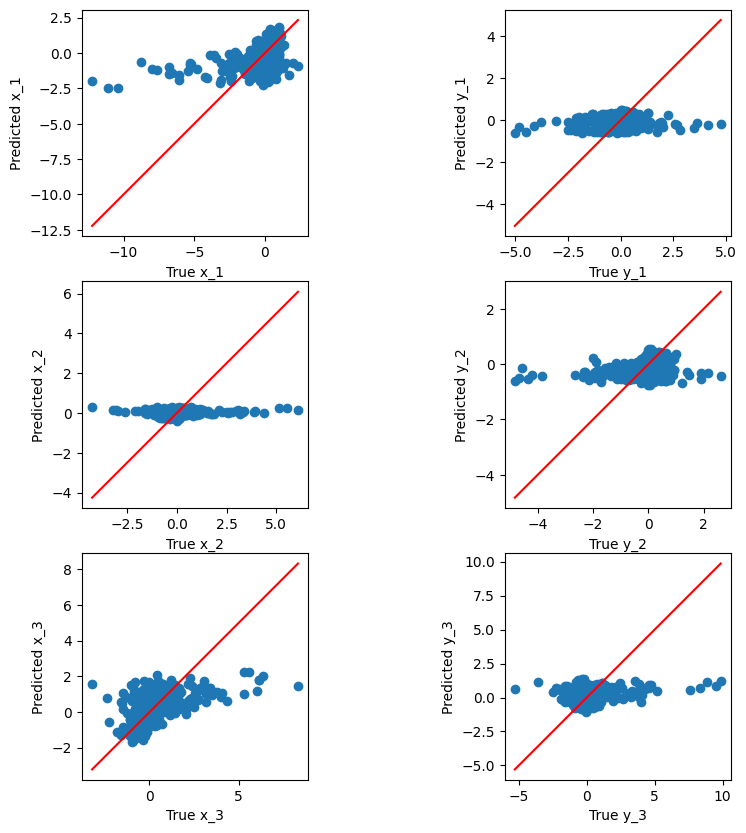

Regularizations
Ridge regression
train: 1.4122237520651397
validation: 1.2771294119454057


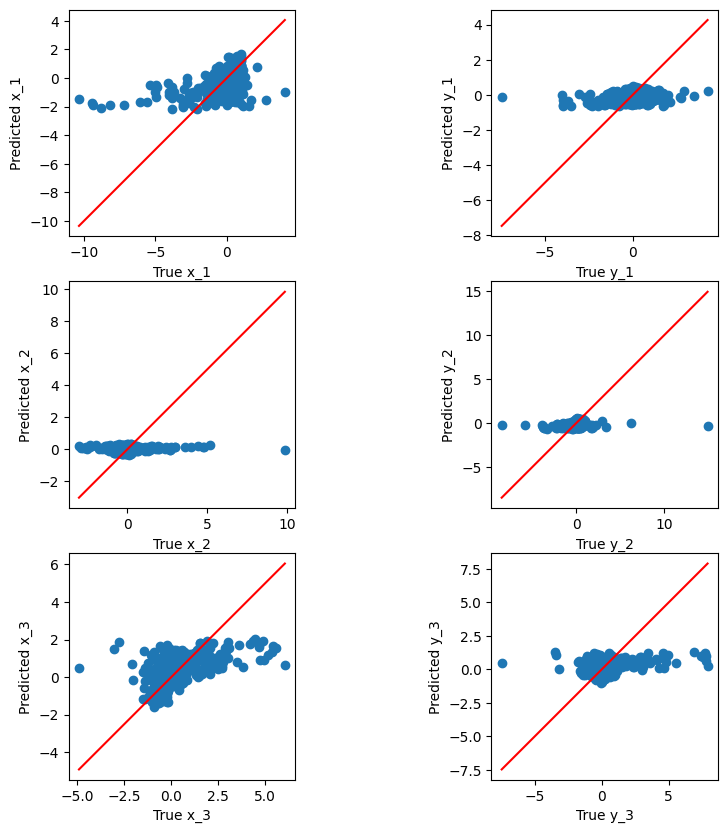

Lasso regression
train: 1.4931515191048248
validation: 1.3700534078077367


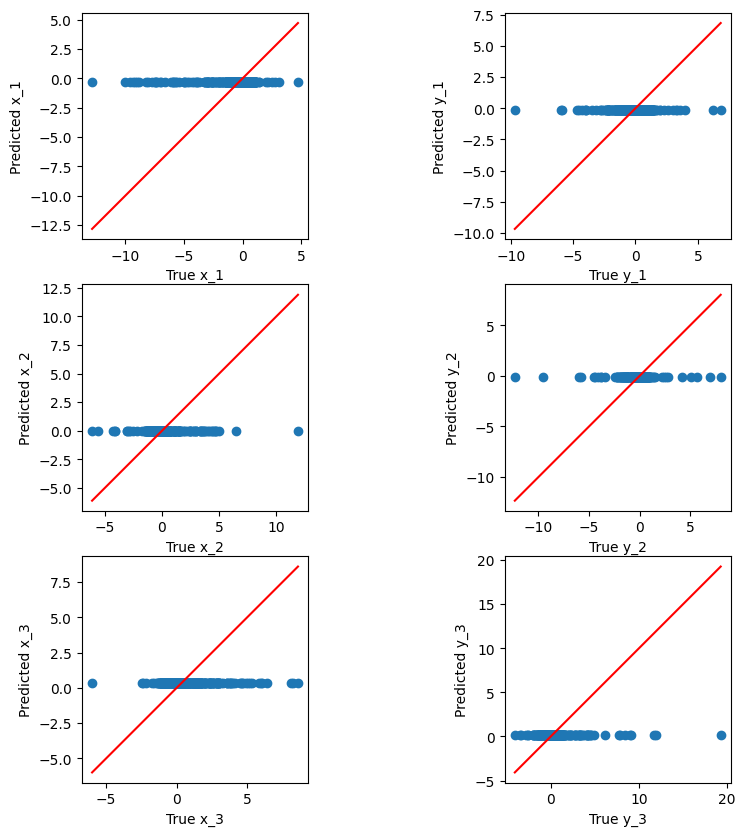

In [49]:
print("Normal linear regression")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression()) 
])
y_pred_train, y_pred_val, linear_model = train_model(pipeline, X_train, X_val, y_train, y_val)

print("train: "+str(root_mean_squared_error(y_pred_train, y_train)))
print("validation: "+str(root_mean_squared_error(y_pred_val, y_val)))
plot_y_yhat(np.array(y_val), np.array(y_pred_val), "Linear Regression")

print("Regularizations")
print("Ridge regression")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])
y_pred_train, y_pred_val, linear_model_ridge = train_model(pipeline, X_train, X_val, y_train, y_val)
print("train: "+str(root_mean_squared_error(y_pred_train, y_train)))
print("validation: "+str(root_mean_squared_error(y_pred_val, y_val)))
plot_y_yhat(np.array(y_val), np.array(y_pred_val), "Linear Regression Ridge")

print("Lasso regression")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso(alpha=5))
])
y_pred_train, y_pred_val, linear_model_lasso = train_model(pipeline, X_train, X_val, y_train, y_val)
print("train: "+str(root_mean_squared_error(y_pred_train, y_train)))
print("validation: "+str(root_mean_squared_error(y_pred_val, y_val)))
plot_y_yhat(np.array(y_val), np.array(y_pred_val), "Linear Regression Lasso")

In [50]:
# Test multiple Linear Regressions - also predict for the test model
X_train, X_val, y_train, y_val = custom_train_test_split(X, y, drop=True, columns_to_drop=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'])

In [51]:
# Use GridSearch to find the best parameters
# Define the parameter grid for Linear Regression
param_grid_lr = {
    'regressor__fit_intercept': [True, False]
}

# Define the parameter grid for Ridge Regression
param_grid_ridge = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0],
}

# Define the parameter grid for Lasso Regression
param_grid_lasso = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0],
}

# Perform Grid Search for Linear Regression
grid_search_lr = GridSearchCV(pipeline, param_grid_lr, cv=5, scoring='neg_root_mean_squared_error')
grid_search_lr.fit(X_train, y_train)
print("Best parameters for Linear Regression:", grid_search_lr.best_params_)
print("Best RMSE for Linear Regression:", -grid_search_lr.best_score_)

# Perform Grid Search for Ridge Regression
pipeline.set_params(regressor=Ridge())
grid_search_ridge = GridSearchCV(pipeline, param_grid_ridge, cv=5, scoring='neg_root_mean_squared_error')
grid_search_ridge.fit(X_train, y_train)
print("Best parameters for Ridge Regression:", grid_search_ridge.best_params_)
print("Best RMSE for Ridge Regression:", -grid_search_ridge.best_score_)

# Perform Grid Search for Lasso Regression
pipeline.set_params(regressor=Lasso())
grid_search_lasso = GridSearchCV(pipeline, param_grid_lasso, cv=5, scoring='neg_root_mean_squared_error')
grid_search_lasso.fit(X_train, y_train)
print("Best parameters for Lasso Regression:", grid_search_lasso.best_params_)
print("Best RMSE for Lasso Regression:", -grid_search_lasso.best_score_)

Best parameters for Linear Regression: {'regressor__fit_intercept': True}
Best RMSE for Linear Regression: 1.4563266814471694
Best parameters for Ridge Regression: {'regressor__alpha': 100.0}
Best RMSE for Ridge Regression: 1.372547616632291
Best parameters for Lasso Regression: {'regressor__alpha': 0.1}
Best RMSE for Lasso Regression: 1.380671780880919


## Polynomial Linear Regressions

Cláudia Soares — Ontem às 22:09<br>
Yes. But do not rely on one single draw of the data sample<br>
Say you do 5 or 7 draws<br>
Then compute avg rmse and stdev of rmse<br>
Of these 5 or 7 runs<br>
Ricardo Pereira 57912 — Ontem às 22:13<br>
whats the difference between doing the average rmse (and choosing the best from there) and an histogram that shows me the amount of times a certain degree got the best model? 🤔<br>
Cláudia Soares — Ontem às 22:30<br>
I mentioned average AND standard deviation. This might be more practical if you want to compare across different degrees. If you can compare histograms I'm good  😀<br>
Another option, if you prefer a plot to a table, is to use the empírical cdf.<br>
There is one in the seaborn toolbox<br>

range(1, 7)
Degree: 1, RMSE: 1.7259294839442454, Number of features: 8
Degree: 2, RMSE: 1.8075253583093935, Number of features: 36
Degree: 3, RMSE: 1.9022392819724907, Number of features: 120
Degree: 4, RMSE: 2.535370483052662, Number of features: 330
Degree: 5, RMSE: 5.889984260486567, Number of features: 792
Degree: 6, RMSE: 10.854221156785627, Number of features: 1716
Best Degree: 1, Best RMSE: 1.7259294839442454
Degree: 1, RMSE: 1.6840399174725205, Number of features: 8
Degree: 2, RMSE: 1.941048435788615, Number of features: 36
Degree: 3, RMSE: 2.0299257517236184, Number of features: 120
Degree: 4, RMSE: 1.9002495620662678, Number of features: 330
Degree: 5, RMSE: 1.999290959762089, Number of features: 792
Degree: 6, RMSE: 3.011451943768877, Number of features: 1716
Best Degree: 1, Best RMSE: 1.6840399174725205
Degree: 1, RMSE: 1.6075828686439648, Number of features: 8
Degree: 2, RMSE: 1.747540604384486, Number of features: 36
Degree: 3, RMSE: 1.7007993428785684, Number of features

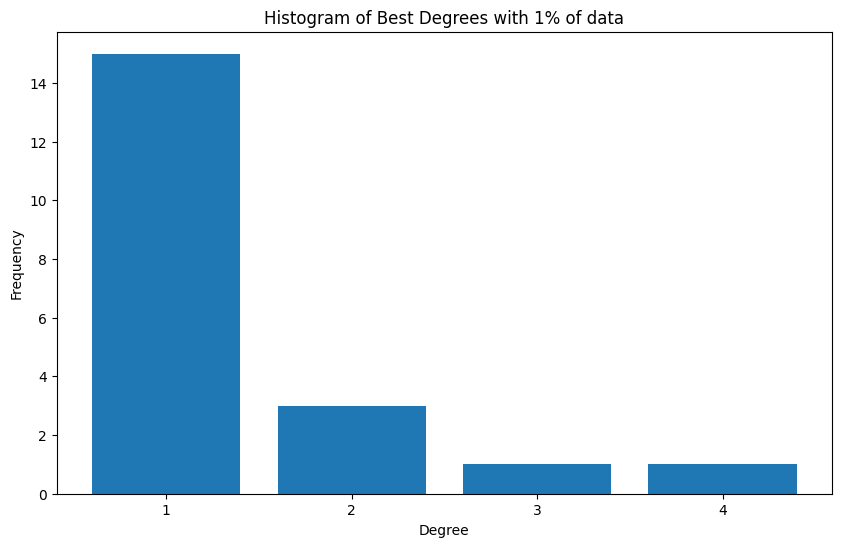

range(1, 7)
Degree: 1, RMSE: 2.11201079625804, Number of features: 8
Degree: 2, RMSE: 2.11030315366239, Number of features: 36
Degree: 3, RMSE: 2.085618343147413, Number of features: 120
Degree: 4, RMSE: 2.0372514055699145, Number of features: 330
Degree: 5, RMSE: 2.0361563782974943, Number of features: 792
Degree: 6, RMSE: 2.0869993065896986, Number of features: 1716
Best Degree: 5, Best RMSE: 2.0361563782974943
Degree: 1, RMSE: 1.1894522816404525, Number of features: 8
Degree: 2, RMSE: 1.1783586522770553, Number of features: 36
Degree: 3, RMSE: 1.18604138758037, Number of features: 120
Degree: 4, RMSE: 1.1890997190509196, Number of features: 330
Degree: 5, RMSE: 1.1449922590132797, Number of features: 792
Degree: 6, RMSE: 1.137632168230861, Number of features: 1716
Best Degree: 6, Best RMSE: 1.137632168230861
Degree: 1, RMSE: 1.6280084590757884, Number of features: 8
Degree: 2, RMSE: 1.599354295975451, Number of features: 36
Degree: 3, RMSE: 1.5917693662309453, Number of features: 12

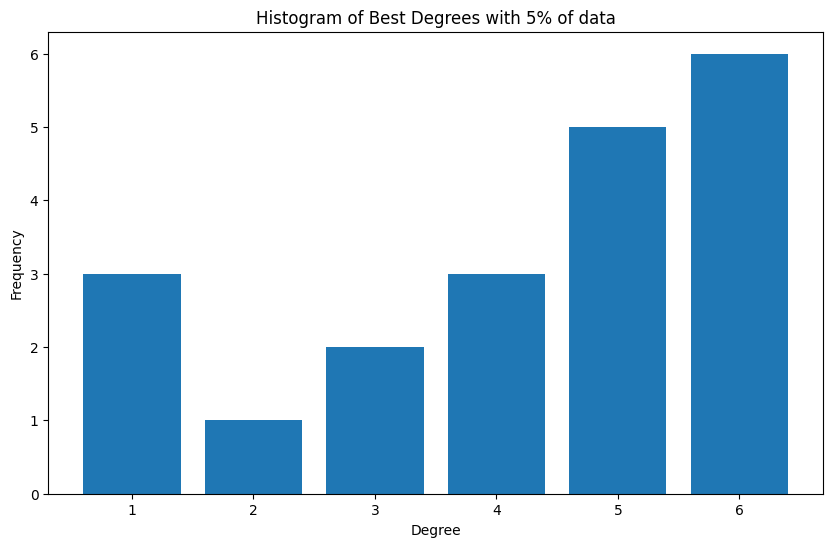

range(1, 7)
Degree: 1, RMSE: 1.3145368803582986, Number of features: 8
Degree: 2, RMSE: 1.3052974653921898, Number of features: 36
Degree: 3, RMSE: 1.3130927480746986, Number of features: 120
Degree: 4, RMSE: 1.3457231310390283, Number of features: 330
Degree: 5, RMSE: 1.348803258936642, Number of features: 792
Degree: 6, RMSE: 1.3051210613987878, Number of features: 1716
Best Degree: 6, Best RMSE: 1.3051210613987878
Degree: 1, RMSE: 2.4480147939791292, Number of features: 8
Degree: 2, RMSE: 11.15032452485024, Number of features: 36
Degree: 3, RMSE: 10.570541188166322, Number of features: 120
Degree: 4, RMSE: 45.03769301042007, Number of features: 330
Degree: 5, RMSE: 49.70145277384242, Number of features: 792
Degree: 6, RMSE: 52.51543670679104, Number of features: 1716
Best Degree: 1, Best RMSE: 2.4480147939791292
Degree: 1, RMSE: 1.4678905049815059, Number of features: 8
Degree: 2, RMSE: 1.4579522258624493, Number of features: 36
Degree: 3, RMSE: 1.4195382659728033, Number of feature

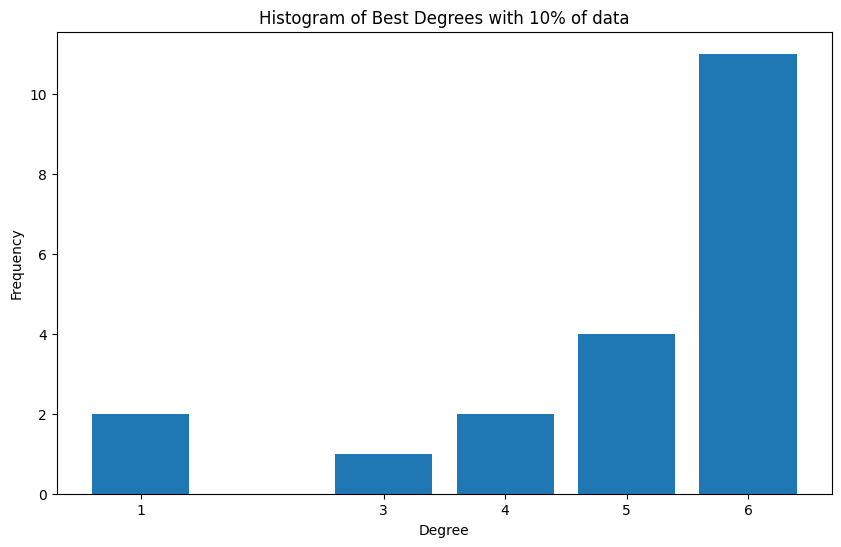

range(1, 7)
Degree: 1, RMSE: 1.2263839609064713, Number of features: 8
Degree: 2, RMSE: 1.1885119070931822, Number of features: 36
Degree: 3, RMSE: 1.1378034292977681, Number of features: 120
Degree: 4, RMSE: 1.093150935935315, Number of features: 330
Degree: 5, RMSE: 1.078109176211665, Number of features: 792
Degree: 6, RMSE: 1.0804103545452712, Number of features: 1716
Best Degree: 5, Best RMSE: 1.078109176211665
Degree: 1, RMSE: 1.0177998410412488, Number of features: 8
Degree: 2, RMSE: 0.9968235418745314, Number of features: 36
Degree: 3, RMSE: 1.075424157859187, Number of features: 120
Degree: 4, RMSE: 1.0010160627842037, Number of features: 330
Degree: 5, RMSE: 0.9763097280631706, Number of features: 792
Degree: 6, RMSE: 0.9644582461325107, Number of features: 1716
Best Degree: 6, Best RMSE: 0.9644582461325107
Degree: 1, RMSE: 1.6867947083160761, Number of features: 8
Degree: 2, RMSE: 1.6464023099191138, Number of features: 36
Degree: 3, RMSE: 1.6001184176176446, Number of featur

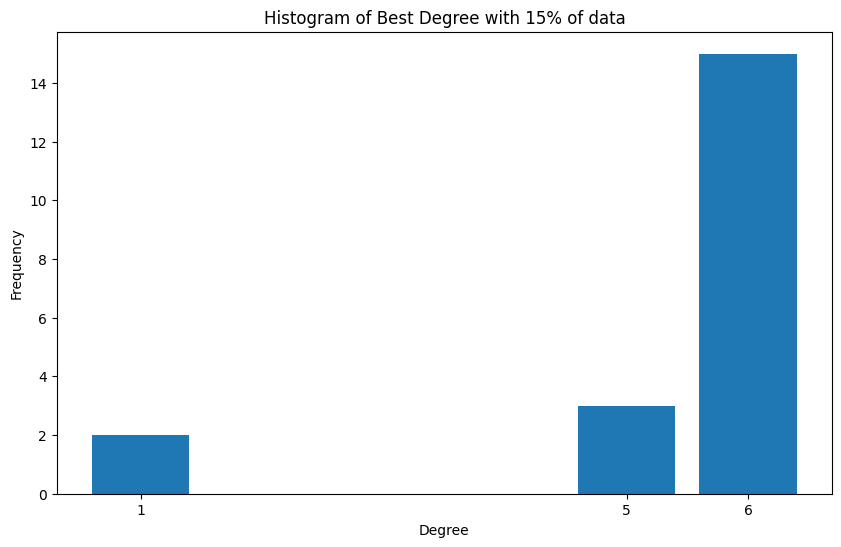

In [62]:
def evaluate_polynomial(X, y, plot_title, regressor=None, ite=20, degrees=range(1,7), sample_size=0.01, ):
    best_rmse_list = []
    best_degree_list = []
    print(degrees)

    for _ in range(ite):
        X_train, _, y_train, _  = custom_train_test_split(X, y, 1-sample_size, False)
        X_train, X_val, y_train, y_val  = custom_train_test_split(X_train, y_train, drop=True, columns_to_drop=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'])
        best_model, best_rmse, best_degree = validate_poly_regression(X_train, y_train, X_val, y_val, regressor=regressor, degrees=degrees, plot=True)
        best_degree_list.append(best_degree)
        best_rmse_list.append(best_rmse)

    # Plot Bar plot of each histogram
    plt.figure(figsize=(10, 6))
    unique_degrees, counts = np.unique(best_degree_list, return_counts=True)
    plt.bar(unique_degrees, counts, tick_label=unique_degrees)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title(plot_title)
    plt.show()  


evaluate_polynomial(X, y, "Histogram of Best Degrees with 1% of data")
# Increase the data to be tested
evaluate_polynomial(X, y, "Histogram of Best Degrees with 5% of data", sample_size=0.05)
evaluate_polynomial(X, y, "Histogram of Best Degrees with 10% of data", sample_size=0.10)
evaluate_polynomial(X, y, "Histogram of Best Degree with 15% of data", sample_size=0.15)

# Ridge and Lasso - TODO
# Ridge
best_model, best_rmse = validate_poly_regression(X_train, y_train, X_val, y_val, degrees=range(1,10), regressor=Ridge()) 
print(f"Best model: {best_model}, Best RMSE: {best_rmse}")

# Lasso
best_model, best_rmse = validate_poly_regression(X_train, y_train, X_val, y_val, degrees=range(1,10), regressor=Lasso()) 
print(f"Best model: {best_model}, Best RMSE: {best_rmse}")


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

# Get 1% of the data
X_train_sample, _, y_train_sample, _ = custom_train_test_split(X, y, test_size=0.99, drop=True, columns_to_drop=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'])

# Define the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Define the parameter grid
param_grid = {
    'poly__degree': range(1, 8)
}

# Perform Grid Search
grid_search_poly = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search_poly.fit(X_train_sample, y_train_sample)

# Print the best parameters and the best RMSE
print("Best parameters for Polynomial Regression:", grid_search_poly.best_params_)
print("Best RMSE for Polynomial Regression:", -grid_search_poly.best_score_)

In [ ]:
y_grid_search_poly = grid_search_poly.predict(X_test.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3','trajectory_id', 'Id']))
print("RMSE for Polynomial Regression on Test:", root_mean_squared_error(y_grid_search_poly, y_test.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3','trajectory_id', 'Id'])))

From a brief analysis and a few runs, we've come to the conclusion, using just 1% of the dataset to choose a Polynomial regression, gives results that are very inconsistent. 

## Feature Engineering

In [ ]:
sns.pairplot(df.sample(200))

In [ ]:
# Calculate the correlation matrix
corr = df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

# Sort the correlations by their absolute values
sorted_corr = corr.abs().unstack().sort_values(kind="quicksort", ascending=False)
sorted_corr = sorted_corr[sorted_corr != 1]  # Remove self-correlations

# Function to evaluate model performance after eliminating a variable
def evaluate_model_after_elimination(X, y, variable_to_drop):
    X_dropped = X.drop(columns=[variable_to_drop])
    X_train, X_val, y_train, y_val = custom_train_test_split(X_dropped, y, drop=True, columns_to_drop=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'])
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression()) 
    ])
    
    y_pred_train, y_pred_val, model = train_model(pipeline, X_train, X_val, y_train, y_val)
    
    train_rmse = root_mean_squared_error(y_pred_train, y_train)
    val_rmse = root_mean_squared_error(y_pred_val, y_val)
    
    plot_y_yhat(np.array(y_val), np.array(y_pred_val), f"Linear Regression without {variable_to_drop}")
    
    return train_rmse, val_rmse

# Iterate over the most redundant variables and evaluate the model performance
variables_to_evaluate = sorted_corr.index.get_level_values(1).unique()
baseline_rmse = root_mean_squared_error(y_pred_val, y_val)

results = []
for variable in variables_to_evaluate:
    train_rmse, val_rmse = evaluate_model_after_elimination(X, y, variable)
    results.append((variable, train_rmse, val_rmse))

# Print the results
for variable, train_rmse, val_rmse in results:
    print(f"Variable: {variable}, Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}")